## Курсовая работа
##### по курсу "Машинное обучение"

### Вариант решения соревнования по анализу данных "Quora question pairs"

### Выполнили:
* Исаев Илья, M4139
* Суворов Дмитрий, M4139

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

from subprocess import check_output
print("Файлы с данными\n", check_output(["ls", "../input"]).decode("utf8"))

Файлы с данными
 test.csv
train.csv



In [9]:
train = pd.read_csv('../input/train.csv').fillna(" ")
train = train.dropna(how="any").reset_index(drop=True)

#### Содержимое датасета

In [12]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Посмотрим сколько дубликатов:

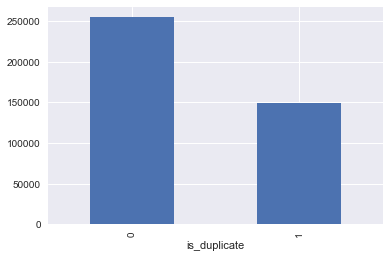

In [4]:
train.groupby("is_duplicate")['id'].count().plot.bar()

Для выделения признаков из предложений воспользуемся CountVectorizer

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
Bag = CountVectorizer(max_df=0.999, min_df=50, max_features=300, 
                                      analyzer='char', ngram_range=(1,2), 
                                      binary=True, lowercase=True)

Настройка параметров CountVectorizer
-----------------------------------------------------

Для получения score = 0.31675 нужно использовать следующее параметры: 

 - max_features = 300000 - количество отбираемых признаков в корпусе
 - min_df = 50 - минимальная частота появления слова
 - ngram_range = (1,10) - минимальный и максимальный размер N-граммы

С этими параметрами скрипт отрабатывает на MacBook Pro Early 2015 в течение часа. Для демонстрации уменьшим значения параметров до следующих: 

 - max_features = 300
 - min_df = 50
 - ngram_range = (1,2)

In [18]:
dataset = pd.concat((train.question1,train.question2)).unique()
Bag.fit(dataset)

CountVectorizer(analyzer='char', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.999, max_features=300, min_df=50,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [19]:
question1 = Bag.transform(train['question1'])
question2 = Bag.transform(train['question2'])

In [20]:
X = -(question1 != question2).astype(int)
y = train['is_duplicate'].values

Следует заметить, что X принимает следующие значения:

 - 0, если конкретная последовательность букв присутствует в обоих вопросах.
 - -1, если конкретная последовательность букв присутствует в одном вопросе, но не присутствует в другом.

<center><h3>Применим логистическую регрессию</h3></center>

In [21]:
logisticRegressor = linear_model.LogisticRegression(C=0.1, solver='sag', 
                                                    class_weight={1: 0.472008228977, 0: 1.30905513329})
logisticRegressor.fit(X, y)

LogisticRegression(C=0.1, class_weight={1: 0.472008228977, 0: 1.30905513329},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False)

Стоит заметить: class_weight принимает значения {0.472008228977,  1.30905513329} по следующим причинам. 


Оказывается, что распределение меток на трейне и тесте разное, то есть  распределение меток на тесте просто скошено.  А прогноз модели следует делать по следующей формуле: 

$$f(x) = \frac{\gamma_1 x}{\gamma_1 x + \gamma_0 (1-x)},$$

где $$\gamma_0 = 1.30905513329, \gamma_1 = 0.472008228977.$$ 

И график этой функции выглядит следующим образом: 

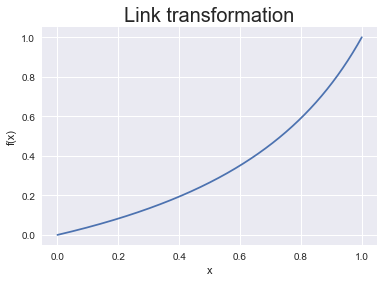

In [22]:
gamma_0 = 1.30905513329
gamma_1 = 0.472008228977
def link_function(x):
    return gamma_1*x/(gamma_1*x + gamma_0*(1 - x))

support = np.linspace(0, 1, 1000)
values = link_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Link transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

### Применим к тестовой выборке

In [23]:
test = pd.read_csv('../input/test.csv')
test.ix[test['question1'].isnull(),['question1','question2']] = ' '
test.ix[test['question2'].isnull(),['question1','question2']] = ' '

In [ ]:
%%time
test.ix[test['question1'].isnull(),['question1','question2']] = ' '
test.ix[test['question2'].isnull(),['question1','question2']] = ' '

Question1 = Bag.transform(test['question1'])
Question2 = Bag.transform(test['question2'])

X_test = -(Question1 != Question2).astype(int)

separators= [750000,1500000]
testPredictions1 = logisticRegressor.predict_proba(X_test[:separators[0],:])[:,1]
testPredictions2 = logisticRegressor.predict_proba(X_test[separators[0]:seperators[1],:])[:,1]
testPredictions3 = logisticRegressor.predict_proba(X_test[separators[1]:,:])[:,1]
testPredictions = np.hstack((testPredictions1,testPredictions2,testPredictions3))

In [16]:
print(testPredictions[0:10])

[ 0.04100689  0.25385036  0.15946211  0.09187033  0.33561599  0.0081948
  0.22838802  0.2902334   0.34340652  0.10686361]


### Делаем сабмит

In [ ]:
submissionName = 'quora_submission'

submission = pd.DataFrame()
submission['test_id'] = test['test_id']
submission['is_duplicate'] = testPredictions
submission.to_csv(submissionName + '.csv', index=False)

Таким образом, мы добились достаточно неплохих результатов даже с такой простой моделью.